## Import

In [159]:
pip install feature_engine

In [160]:
import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from feature_engine.selection import SmartCorrelatedSelection


import warnings

# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
train_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/train_data.pqt")
test_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/test_data.pqt")
nan_3_month_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/nan_3_month_df.pqt")


cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]


train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

df = pd.concat([train_df, test_df], ignore_index = True)

# Feature engineering

### Handaling missing values

### Восстановление категориальных данных

Нет в моем списке

In [6]:
nan_3_month_df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_cred_e_oper_3m,cnt_days_cred_e_oper_3m,sum_deb_f_oper_3m,cnt_deb_f_oper_3m,cnt_days_deb_f_oper_3m,sum_cred_f_oper_3m,sum
0,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,1,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,6
2,2,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,6
3,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,4,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,False,False,False,False,False,False,False,False,False,...,True,True,False,True,True,False,True,True,False,64
299996,299996,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
299997,299997,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
299998,299998,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,6


In [24]:
df[15:18]

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
15,5,month_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{},{α}
16,5,month_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{},{α}
17,5,month_3,NaN,NaN,NaN,NaN,channel_code_21,NaN,NaN,index_city_code_5,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{α},{α}


In [6]:
# x.isna().any()
def restore_cal(x):
    if x.isna().any() and not x.isna().all():
      return x.fillna(x.dropna().iloc[0])
    return x


In [11]:
df['okved'] = df.groupby('id')['okved'].apply(lambda x: restore_cal(x)).reset_index()['okved']

In [163]:
# x.isna().any()
def restore_num(x):
  if len(x) != 3:
    return x

  # 3 nan
  if x.isna().sum() == 3:
    v1 = mean_of_col + np.random.uniform(-var_of_col, var_of_col)
    v2 = v1 * (1 + aver_diff)
    v3 = v1 * (1 + aver_diff) * (1+aver_diff)
    x.iloc[0] =  v1
    x.iloc[1] =  v2
    x.iloc[2] =  v3
    return x

  # 2 Nan
  elif x.isna().sum() == 2:
    # month_1 - num
    if not np.isnan(x.iloc[0]):

      v1 = x.iloc[0]

      x.iloc[1] = v1 * (1+aver_diff)
      x.iloc[2] = v1 * (1+aver_diff)* (1+aver_diff)

      return x

    # month_2 - num
    if not np.isnan(x.iloc[1]):

      v1 = x.iloc[1]
      x.iloc[0] = v1 / (1 + aver_diff)
      x.iloc[2] = v1 * (1+aver_diff)* (1+aver_diff)


      return x


    # month_3 - num
    if not np.isnan(x.iloc[2]):
      v1 = x.iloc[2]
      x.iloc[0] = v1 / (1 + aver_diff) / (1 + aver_diff)
      x.iloc[1] = v1 / (1 + aver_diff)


      return x



  # 1 Nan
  elif x.isna().sum() == 1:

    # month_1 - Nan
    if np.isnan(x.iloc[0]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna(v1 * (v1/v2))
      return x

    # month_2 - Nan
    if np.isnan(x.iloc[1]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna((v1 + v2)/2)

      return x

    # month_3 - Nan
    if np.isnan(x.iloc[2]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna(v2 * (v2/v1))
      return x


  else:

    return x



In [130]:
balance_amt_min

NameError: name 'balance_amt_min' is not defined

In [89]:
df[:1000].groupby('id')['balance_amt_min'].pct_change().mean() - 1

-1.1836496491861426

In [150]:
df['balance_amt_min'].value_counts().sort_index()

balance_amt_min
-0.1260    128140
-0.1260      1128
-0.1260       711
-0.1260       541
-0.1260       520
            ...  
88.6380         1
90.5838         1
91.2464         1
91.4491         1
91.4508         1
Name: count, Length: 382491, dtype: int64

In [157]:
df[:21].groupby('id')['balance_amt_min'].apply(lambda x: restore_num(x)).reset_index()['balance_amt_min']

0     1.2872
1     2.4586
2     0.4300
3    -0.1140
4    -0.1193
5    -0.1141
6    -0.1228
7    -0.1228
8    -0.1124
9    -0.1257
10   -0.1260
11   -0.1258
12   -0.1256
13   -0.1087
14   -0.1257
15    0.8953
16   -0.9356
17    0.9776
18   -0.1053
19    0.1025
20   -0.1249
Name: balance_amt_min, dtype: float64

In [164]:
start_time = time.time()

mean_of_col = df['balance_amt_min'].mean()
var_of_col = df['balance_amt_min'].var()


aver_diff = df.groupby('id')['balance_amt_min'].pct_change().mean() - 1



df['balance_amt_min'] = df.groupby('id')['balance_amt_min'].apply(lambda x: restore_num(x)).reset_index()['balance_amt_min']

end_time = time.time()


In [174]:
for column in df.select_dtypes(include = 'number').columns[1:]:

  start_time = time.time()

  mean_of_col = df[column].mean()
  var_of_col = df[column].var()


  aver_diff = df.groupby('id')[column].pct_change().mean() - 1



  df[column] = df.groupby('id')[column].apply(lambda x: restore_num(x)).reset_index()[column]

  end_time = time.time()

  print(f'{column} обработан за {end_time - start_time}')

balance_amt_avg обработан за 100.88029456138611
balance_amt_max обработан за 97.66140127182007
balance_amt_min обработан за 114.36498045921326


KeyboardInterrupt: 

Проверка

In [175]:
df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,NaN,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,NaN,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{},NaN
890116,299998,month_6,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.2011,0.2509,0.3745,NaN,NaN
890117,299999,month_4,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0976,0.5509,0.5744,-0.1014,0.2527,0.4405,{α},NaN
890118,299999,month_5,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0479,0.5551,0.6966,-0.0349,0.2535,0.4734,{α},NaN


In [177]:
check_df = pd.read_parquet("/content/train_df_checkpoint_8.parquet")
check_df


,id,date,balance_amt_avg,balance_amt_min,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,cnt_deb_h_oper_1m,cnt_days_deb_h_oper_1m,sum_cred_h_oper_1m,cnt_cred_h_oper_1m,cnt_days_cred_h_oper_1m,cnt_b_oper_3m,sum_deb_e_oper_3m,sum_deb_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,1.2872,channel_code_5,city_23,city_type_0,index_city_code_39,-0.4886,-0.1351,...,0.6541,0.3879,1.1710,0.6489,0.6616,0.5173,0.3566,0.8976,"{α, γ}",{other}
1,0,month_2,1.0496,2.4586,channel_code_5,city_23,city_type_0,index_city_code_39,-0.4886,-0.1351,...,0.6528,0.2588,0.4104,0.6335,0.5649,0.5173,0.3022,0.7850,"{α, γ}",{other}
2,0,month_3,0.6927,0.4300,channel_code_5,city_23,city_type_0,index_city_code_39,-0.4886,-0.1351,...,0.6534,0.3879,0.5528,0.6296,0.6616,0.5173,0.3468,0.8770,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.1140,channel_code_2,city_14,city_type_0,index_city_code_157,0.3243,1.2587,...,0.6611,0.4201,-0.1710,0.5891,0.0810,0.5173,0.1915,0.3693,{other},{other}
4,1,month_2,-0.0950,-0.1193,channel_code_2,city_14,city_type_0,index_city_code_157,0.3243,1.2587,...,0.6580,0.3556,-0.1307,0.6007,0.3390,0.5173,0.0685,0.0673,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.1568,-0.1260,channel_code_9,city_14,city_type_0,index_city_code_77,0.3243,-1.0643,...,NaN,0.0933,-0.1718,NaN,NaN,NaN,-0.1530,-0.1656,{},{}
599996,199998,month_3,-0.1568,-0.1260,channel_code_9,city_14,city_type_0,index_city_code_77,0.3243,-1.0643,...,0.6504,0.0975,-0.1718,0.5881,0.0487,0.5173,-0.1530,-0.1656,{α},{}
599997,199999,month_1,-0.1567,-0.1258,channel_code_14,city_1876,city_type_0,index_city_code_195,1.7179,1.7621,...,NaN,0.1843,-0.1718,NaN,NaN,NaN,-0.1530,-0.1656,{},{}
599998,199999,month_2,-0.1567,-0.1258,channel_code_14,city_1876,city_type_0,index_city_code_195,1.7179,1.7621,...,NaN,0.1925,-0.1718,NaN,NaN,NaN,-0.1530,-0.1656,{},{}


In [184]:
(df['balance_amt_min'][:600000] - check_df['balance_amt_min']).value_counts()

balance_amt_min
0.0000     542740
-0.2287      7996
0.8528       7904
-0.2285       439
0.8522        439
            ...  
0.8481          1
-0.8051         1
0.5898          1
-0.0638         1
0.5087          1
Name: count, Length: 36636, dtype: int64

In [187]:
df['balance_amt_min'].isna().sum()

95060

In [ ]:
def check_column(x):
    if x.isna().any() and not x.isna().all():
      return x.fillna(x.dropna().iloc[0])
    return x

In [47]:
df

,Дата,Цена акции,Изменение цены
0,2024-04-01,100.0000,NaN
1,2024-04-02,NaN,0.0000
2,2024-04-03,110.0000,0.1000
3,2024-04-04,90.0000,-0.1818


In [ ]:
for column in df.column(exclude ='nubmer'):
  df.d.groupby('id')[column].apply(lambda x: restore_cal(x)).reset_index()

In [12]:
df['okved'].isna().sum()

3068

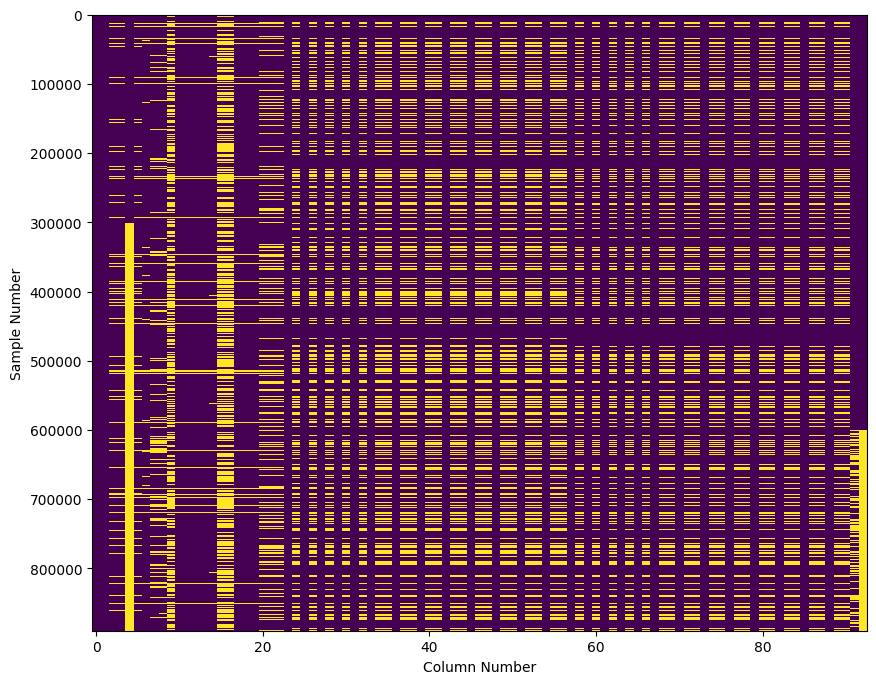

In [126]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.show()

In [ ]:
df.groupby('id')['balance_amt_min'].apply(lambda x: x.isna().any()).value_counts()